## Data Preparation


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
from scipy.stats import pointbiserialr
from scipy.stats import pearsonr

#include utils directory
import sys
sys.path.append('..')

from utils.files import *
DATA_PATH = os.path.join('..', 'data')

from utils.metrics import *

In [21]:
# Players
players_teams_df = pd.read_csv(os.path.join(DATA_PATH, DATA_PLAYERS_TEAMS))
pt_df = preparePlayersTeamsDf(players_teams_df)

new_pt_df = pd.DataFrame()
for col in ['playerID', 'year', 'tmID']:
    new_pt_df[col] = pt_df[col]

teams_df = pd.read_csv(os.path.join(DATA_PATH, DATA_TEAMS))
teams_df = prepareTeamsDf(teams_df)

getPer(new_pt_df, pt_df, teams_df) #defined in metrics.py
getEFF(new_pt_df, pt_df) #defined in metrics.py

display(new_pt_df)

# get the average stats for players the previous year
merged_df = teams_df[['year', 'tmID', 'playoff', 'confID']].copy()
for index, row in merged_df.iterrows():
    merged_df.loc[index, 'per'] = new_pt_df[(new_pt_df['year'] == row['year'] - 1) & (new_pt_df['tmID'] == row['tmID'])]['PER'].mean()
    merged_df.loc[index, 'eff'] = new_pt_df[(new_pt_df['year'] == row['year'] - 1) & (new_pt_df['tmID'] == row['tmID'])]['EFF'].mean()


,playerID,year,tmID,PER,EFF
0,abrossv01w,2,MIN,24.671154,0.379433
1,abrossv01w,3,MIN,17.144159,0.277019
2,abrossv01w,4,MIN,23.437776,0.368177
3,abrossv01w,5,MIN,11.492671,0.304348
4,abrossv01w,6,MIN,18.800674,0.332046
...,...,...,...,...,...
1871,zakalok01w,3,PHO,-0.412979,-0.027027
1872,zarafr01w,6,SEA,7.313349,0.243736
1873,zellosh01w,10,DET,31.329987,0.429778
1874,zirkozu01w,4,WAS,0.771033,0.333333


### Team Ratings
#### OER and DER

This metrics are team statistics that the define the efficiency of a team regarding both offensive play (OER) and defensive play (DER).
The formula for both metrics is shown below.

\begin{aligned}
& \text{OER} = \frac{\text{o\_pts}}{\text{o\_fga} + (\text{o\_fta} * 0.9) / 2 + \text{o\_to}}
\end{aligned}

\begin{aligned}
& \text{DER} = \frac{\text{d\_points}}{\text{d\_fga} + (\text{d\_fta} * 0.9) / 2 + \text{d\_to}}
\end{aligned}

In [22]:
teams_df['oer'] = teams_df['o_pts'] / (teams_df['o_fga'] + (teams_df['o_fta'] * 0.9) / 2 + teams_df['o_to'])

teams_df['der'] = teams_df['d_pts'] / (teams_df['d_fga'] + (teams_df['d_fta'] * 0.9) / 2 + teams_df['d_to'])

# Merge
teams_df['year'] = teams_df['year'] + 1
#teams_df['playoff_prev'] = teams_df['playoff']
teams_df['rank_prev'] = teams_df['rank']
teams_df.drop(columns=['playoff', 'rank'], inplace=True)
merged_df = pd.merge(merged_df, teams_df[['year', 'tmID', 'oer', 'der']], on=['year', 'tmID'], how='left')

### Coach Ratings

To measure the coach efficiency, we are gonna use a simple win-loss ratio:

\begin{aligned}
& \text{Coach Rating} = \frac{\text{Wins}}{\text{Wins} + \text{Losses}}
\end{aligned}


In [23]:
coaches_df = pd.read_csv(os.path.join(DATA_PATH, DATA_COACHES))
coaches_df = prepareCoachesDf(coaches_df)

coaches_temp = coaches_df[['coachID', 'year', 'tmID']]
merged_df = pd.merge(merged_df, coaches_temp, on=['year', 'tmID'], how='left')
coaches_df['year'] = coaches_df['year'] + 1
coaches_df.drop(columns=['tmID'], inplace=True)
merged_df = pd.merge(merged_df, coaches_df, on=['year', 'coachID'], how='left')
merged_df['coachWLRatio'] = merged_df['coachWLRatio'].fillna(merged_df['coachWLRatio'].mean())
merged_df.drop(columns=['coachID'], inplace=True)

In [24]:
merged_df['playoff'] = merged_df['playoff'].eq('Y').mul(1)
merged_df.drop(columns=['tmID'], inplace=True)
merged_df.dropna(axis=0, inplace=True)
merged_df.head()

,year,playoff,confID,per,eff,oer,der,coachWLRatio
1,10,1,EA,11.398591,0.331618,0.797545,0.891856,0.133333
3,2,1,EA,12.237540,0.306456,0.822222,0.906952,0.391304
4,3,1,EA,16.272494,0.286357,0.824771,0.789112,1.222222
5,4,1,EA,14.459296,0.347968,0.897711,0.853166,1.351403
6,5,0,EA,16.803166,0.341276,0.838661,0.821743,1.000000


In [25]:
# Save the result to a new CSV file
merged_df.to_csv(os.path.join(DATA_PATH, DATA_MERGED), index=False)

## Analysis of engineered features

PER and EFF correlation: 0.553


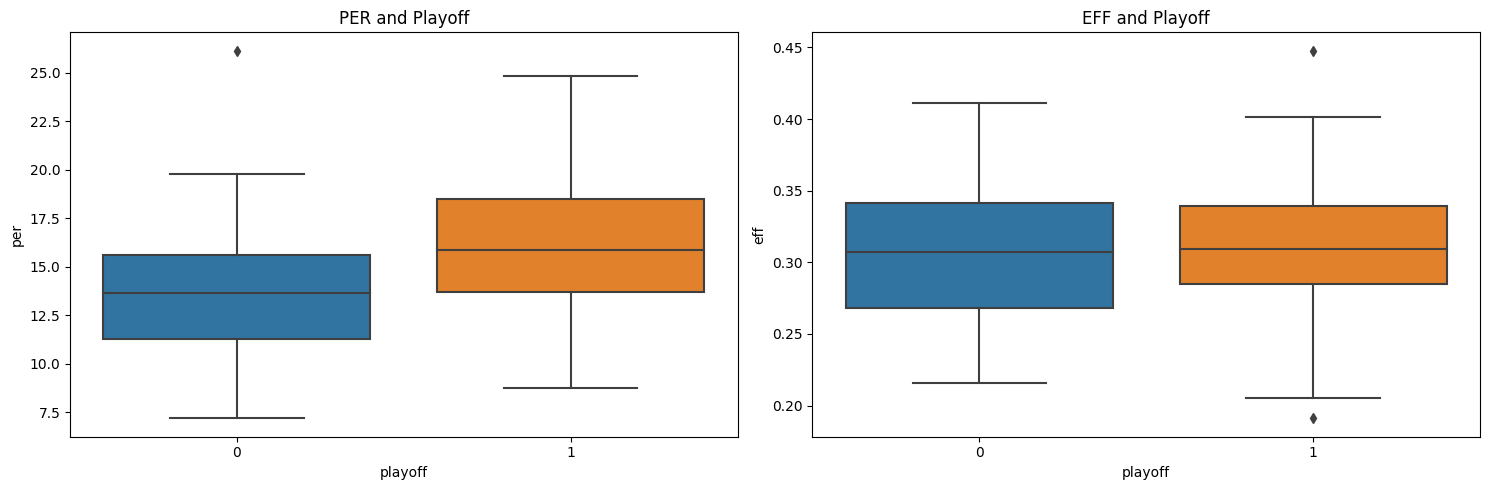

In [26]:
corr = merged_df['per'].corr(merged_df['eff'])
print(f"PER and EFF correlation: {round(corr, 3)}")

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Create a box plot for PER and Playoff
sb.boxplot(x='playoff', y='per', data=merged_df, ax=axes[0])
axes[0].set_title('PER and Playoff')

# Create a box plot for EFF and Playoff
sb.boxplot(x='playoff', y='eff', data=merged_df, ax=axes[1])
axes[1].set_title('EFF and Playoff')

# Adjust the layout
plt.tight_layout()
plt.show()

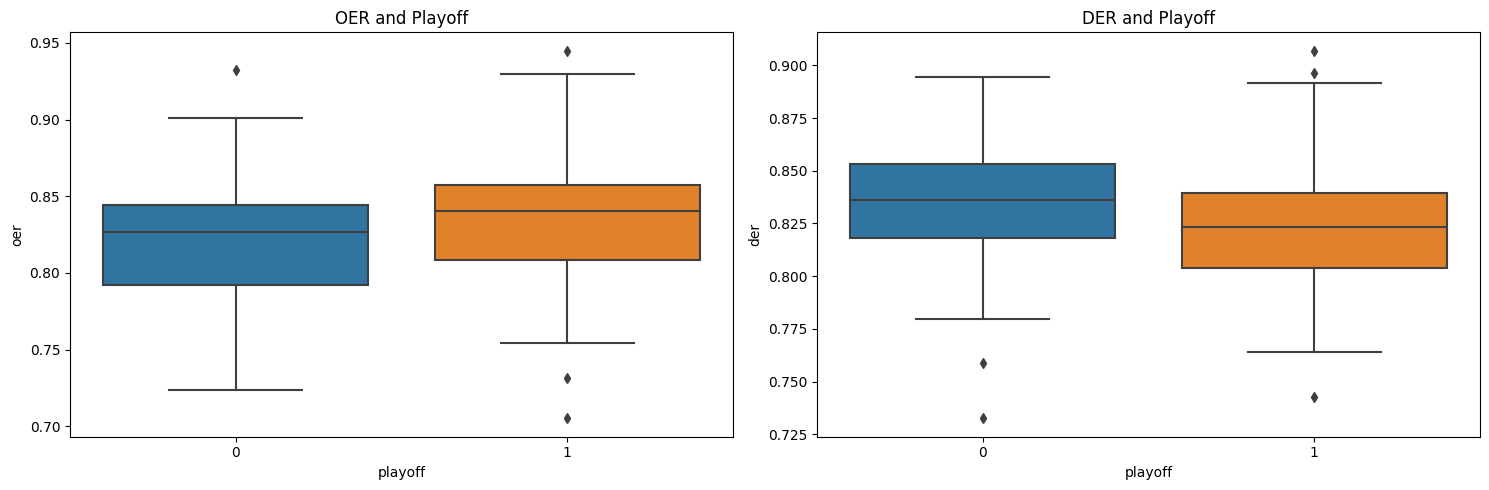

In [27]:

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Create a box plot for OER and Playoff
sb.boxplot(x='playoff', y='oer', data=merged_df, ax=axes[0])
axes[0].set_title('OER and Playoff')

# Create a box plot for DER and Playoff
sb.boxplot(x='playoff', y='der', data=merged_df, ax=axes[1])
axes[1].set_title('DER and Playoff')

# Adjust the layout
plt.tight_layout()
plt.show()


In [28]:
corr_df = pd.DataFrame()
corr_df['variable'] = ['per', 'eff', 'oer', 'der']
for index, row in corr_df.iterrows():
    #corr_df.loc[index, 'corr'], _ = pearsonr(merged_df[row['variable']], merged_df['playoff'])
    #corr_df.loc[index, 'corr'] = merged_df[row['variable']].corr(merged_df['playoff'])
    corr_df.loc[index, 'corr'], _ = pointbiserialr(merged_df[row['variable']], (merged_df['playoff']))

corr_df

test, _ = pointbiserialr(merged_df['eff'], (merged_df['playoff']))
print(test)

0.03428367689048164


### References

<a id="ref1"></a> [1] Maroun, E. (2012, March 7). Understanding advanced statistics: player efficiency rating. Hardwood Paroxysm. https://web.archive.org/web/20170910105350/https://hardwoodparoxysm.com/2012/03/07/understanding-advanced-statistics-player-efficiency-rating/

<a id="ref2"></a> [2] Calculating PER | Basketball-Reference.com. (n.d.). Basketball-Reference.com. https://www.basketball-reference.com/about/per.html